## Behind the pipeline

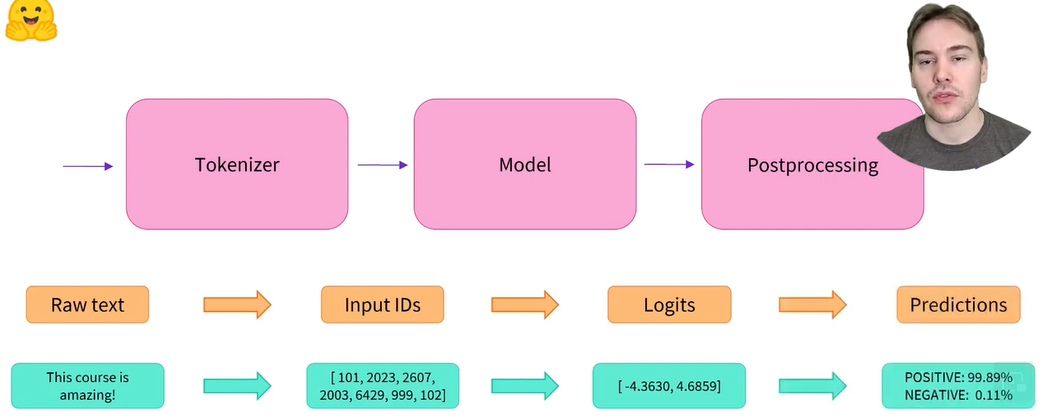

 

### Tokenization

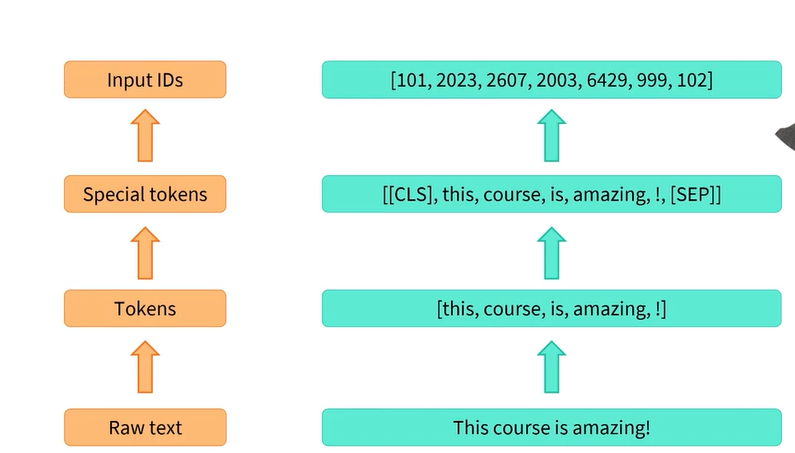





In [2]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [3]:
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt") # Pytorch tensor return
inputs

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])}

In [4]:
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased-finetuned-sst-2-english', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

### Model
``
`

The output of the Transformer model is sent directly to the model head to be processed.

In this diagram, the model is represented by its embeddings layer and the subsequent layers. The embeddings layer converts each input ID in the tokenized input into a vector that represents the associated token. The subsequent layers manipulate those vectors using the attention mechanism to produce the final representation of the sentences.

There are many different architectures available in 🤗 Transformers, with each one designed around tackling a specific task. Here is a non-exhaustive list:

    *Model (retrieve the hidden states)
    *ForCausalLM
    *ForMaskedLM
    *ForMultipleChoice
    *ForQuestionAnswering
    *ForSequenceClassification
    *ForTokenClassification

In [5]:
from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModel.from_pretrained(checkpoint)

In [6]:
outputs = model(**inputs)
print(outputs.last_hidden_state.shape) # batch sz, seq len, hidden sz

torch.Size([2, 16, 768])


For our example, we will need a model with a sequence classification head (to be able to classify the sentences as positive or negative). So, we won’t actually use the AutoModel class, but AutoModelForSequenceClassification:

In [7]:
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)

In [8]:
outputs.logits

tensor([[-1.5607,  1.6123],
        [ 4.1692, -3.3464]], grad_fn=<AddmmBackward0>)

Since we have just two sentences and two labels, the result we get from our model is of shape 2 x 2.

In [9]:
outputs.logits.shape

torch.Size([2, 2])

Those are not probabilities but logits, the raw, unnormalized scores outputted by the last layer of the model. To be converted to probabilities, they need to go through a SoftMax layer (all 🤗 Transformers models output the logits, as the loss function for training will generally fuse the last activation function, such as SoftMax, with the actual loss function, such as cross entropy):

In [10]:
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
predictions

tensor([[4.0195e-02, 9.5980e-01],
        [9.9946e-01, 5.4418e-04]], grad_fn=<SoftmaxBackward0>)

In [11]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}

Now we can conclude that the model predicted the following:

1. First sentence: NEGATIVE: 0.0402, POSITIVE: 0.9598
2. Second sentence: NEGATIVE: 0.9995, POSITIVE: 0.0005

##  Instantiate a Transformers model (PyTorch)

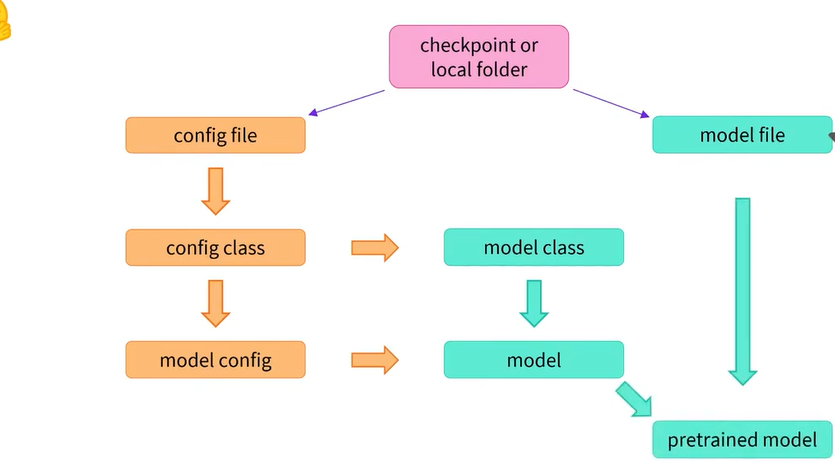

Autoconfig class can be used to extract model config

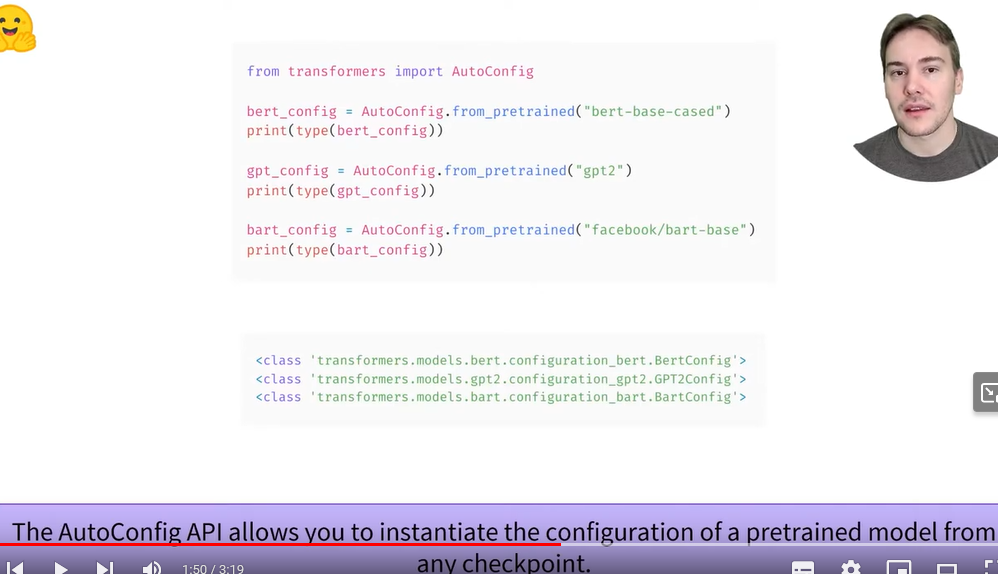

In [12]:

from transformers import BertConfig, BertModel

config = BertConfig()
model = BertModel(config)

# Model is randomly initialized!
config

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.37.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In the code sample above we didn’t use BertConfig, and instead loaded a pretrained model via the bert-base-cased identifier. This is a model checkpoint that was trained by the authors of BERT themselves; you can find more details about it in its model card.

This model is now initialized with all the weights of the checkpoint. It can be used directly for inference on the tasks it was trained on, and it can also be fine-tuned on a new task. By training with pretrained weights rather than from scratch, we can quickly achieve good results.

The weights have been downloaded and cached (so future calls to the from_pretrained() method won’t re-download them) in the cache folder, which defaults to ~/.cache/huggingface/transformers. You can customize your cache folder by setting the HF_HOME environment variable.

In [13]:
model = BertModel.from_pretrained("bert-base-cased")

In [14]:
config2 = BertConfig.from_pretrained("bert-base-cased")
config2

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.37.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

In [15]:
# saving a model and load a model
# model.save_pretrained("directory_on_my_computer")

### Tokenizer

word vs character vs sub-word -> skipped as some intuition already

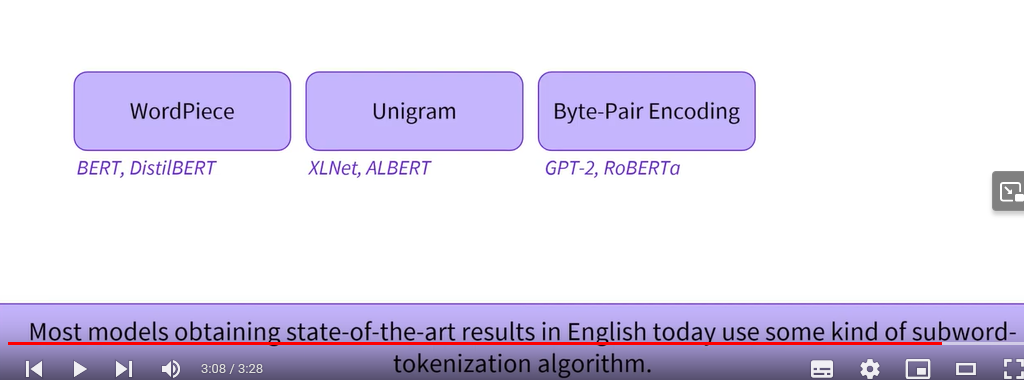

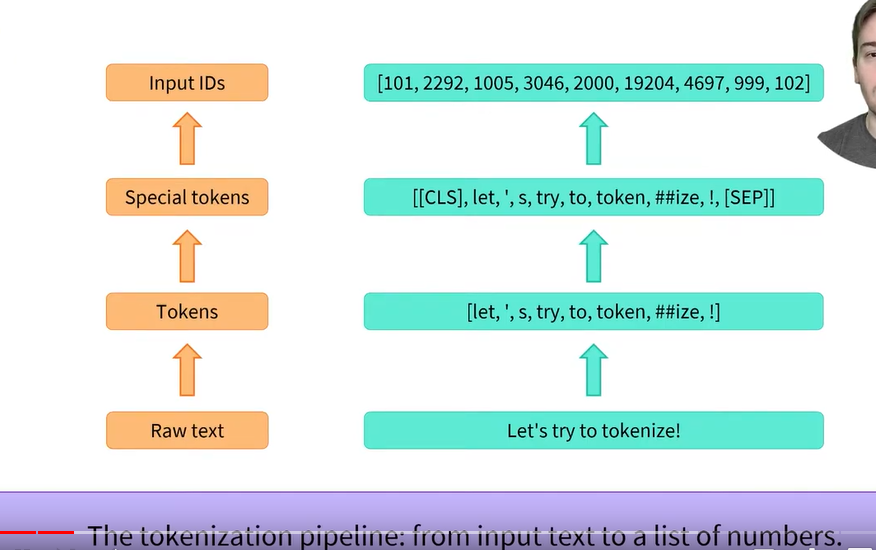

In [2]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [3]:
tokens = tokenizer.tokenize("Let's try to tokenize!")
tokens

['Let', "'", 's', 'try', 'to', 'token', '##ize', '!']

In [4]:
inputs_ids = tokenizer.convert_tokens_to_ids(tokens)
inputs_ids

[2421, 112, 188, 2222, 1106, 22559, 3708, 106]

In [5]:
# special tokens in start and end
# these vary depending on model 
inputs = tokenizer("Let's try to tokenize!")
inputs

{'input_ids': [101, 2421, 112, 188, 2222, 1106, 22559, 3708, 106, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [6]:
tokenizer.decode(inputs["input_ids"])

"[CLS] Let's try to tokenize! [SEP]"

In [ ]:
# saving a tokenizer is the same as saving a model
# tokenizer.save_pretrained("directory_on_my_computer")

### Batch inputs together 

In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence = "I've been waiting for a HuggingFace course my whole life."

tokens = tokenizer.tokenize(sequence)
ids = tokenizer.convert_tokens_to_ids(tokens)
input_ids = torch.tensor(ids)
# This line will fail.
model(input_ids)

IndexError: too many indices for tensor of dimension 1

The problem is that we sent a single sequence to the model, whereas 🤗 Transformers models expect multiple sentences by default. Here we tried to do everything the tokenizer did behind the scenes when we applied it to a sequence. But if you look closely, you’ll see that the tokenizer didn’t just convert the list of input IDs into a tensor, it added a dimension on top of it:

In [12]:
input_ids

tensor([[ 1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,  2607,
          2026,  2878,  2166,  1012]])

In [13]:
tokenized_inputs = tokenizer(sequence, return_tensors="pt")
tokenized_inputs["input_ids"]

tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102]])

In [14]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence = "I've been waiting for a HuggingFace course my whole life."

tokens = tokenizer.tokenize(sequence)
ids = tokenizer.convert_tokens_to_ids(tokens)

input_ids = torch.tensor([ids]) # add a new dim
print("Input IDs:", input_ids)

output = model(input_ids)
print("Logits:", output.logits)

Input IDs: tensor([[ 1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,  2607,
          2026,  2878,  2166,  1012]])
Logits: tensor([[-2.7276,  2.8789]], grad_fn=<AddmmBackward0>)


In [15]:
# we could send a batch to the model

batch_ids = torch.tensor([ids, ids])
print("Input IDs:", batch_ids)

output = model(batch_ids)
print("Logits:", output.logits)



Input IDs: tensor([[ 1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,  2607,
          2026,  2878,  2166,  1012],
        [ 1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,  2607,
          2026,  2878,  2166,  1012]])
Logits: tensor([[-2.7276,  2.8789],
        [-2.7276,  2.8789]], grad_fn=<AddmmBackward0>)


In [16]:
# Padding the inputs

# batch_ids = torch.tensor([ids, ids[:4]])
id_padded = ids[:-2] + [tokenizer.pad_token_id,tokenizer.pad_token_id]
batch_ids = torch.tensor([ids, id_padded])
print("Input IDs:", batch_ids)

output = model(batch_ids)
print("Logits:", output.logits)




We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Input IDs: tensor([[ 1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,  2607,
          2026,  2878,  2166,  1012],
        [ 1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,  2607,
          2026,  2878,     0,     0]])
Logits: tensor([[-2.7276,  2.8789],
        [ 1.6653, -1.3783]], grad_fn=<AddmmBackward0>)


#### Attention masks
Attention masks are tensors with the exact same shape as the input IDs tensor, filled with 0s and 1s: 1s indicate the corresponding tokens should be attended to, and 0s indicate the corresponding tokens should not be attended to (i.e., they should be ignored by the attention layers of the model).


In [75]:
attention_mask = [ [1 if i != 0  else 0 for i in row] for row in batch_ids ]
attention_mask = torch.tensor(attention_mask)

In [76]:
attention_mask

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])

In [77]:
# Padding the inputs

# batch_ids = torch.tensor([ids, ids[:4]])
id_padded = ids[:-2] + [tokenizer.pad_token_id,tokenizer.pad_token_id]
batch_ids = torch.tensor([ids, id_padded])
print("Input IDs:", batch_ids)

output = model(batch_ids, attention_mask=attention_mask )
print("Logits:", output.logits)



Input IDs: tensor([[ 1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,  2607,
          2026,  2878,  2166,  1012],
        [ 1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,  2607,
          2026,  2878,     0,     0]])
Logits: tensor([[-2.7276,  2.8789],
        [-1.8190,  1.9613]], grad_fn=<AddmmBackward0>)


### Putting it all together

- quick cheatcheat good for anki https://huggingface.co/learn/nlp-course/chapter2/7
- 

In [78]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]

tokens = tokenizer(sequences, padding=True, truncation=True, return_tensors="pt")
output = model(**tokens)

In [80]:
tokens

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  2061,  2031,  1045,   999,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

In [82]:
output

SequenceClassifierOutput(loss=None, logits=tensor([[-1.5607,  1.6123],
        [-3.6183,  3.9137]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

## Anki


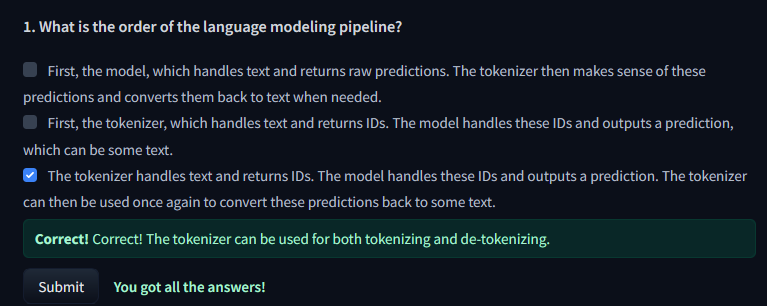

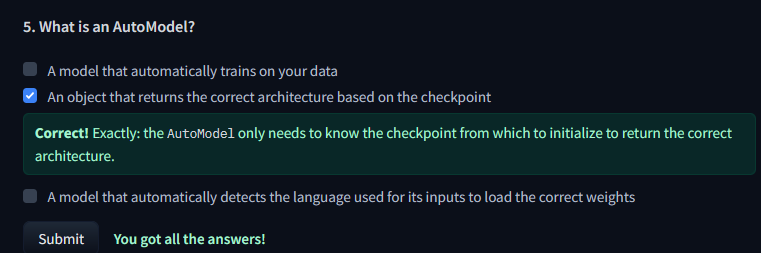

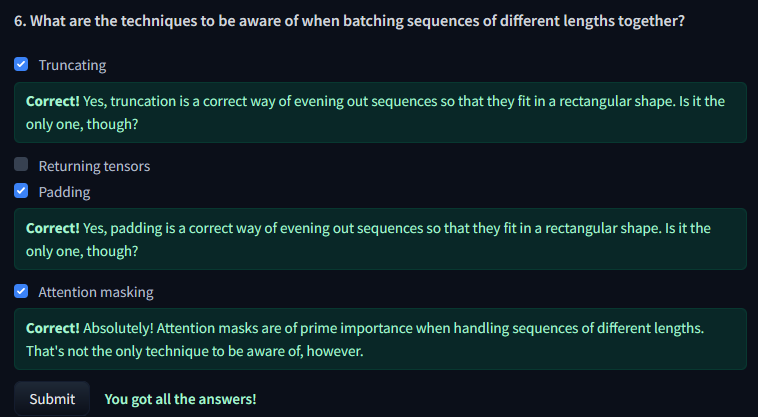

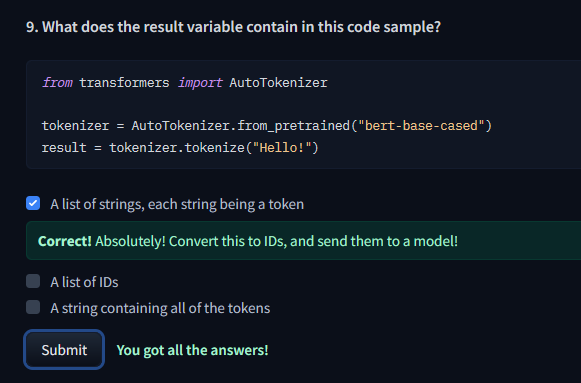